# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../../stork-1")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# change the default color cycle
np.random.seed(20250129)
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=np.random.permutation(cm.batlow(np.linspace(0, 1, 10)))
)

from stork.activations import CustomSpike
from stork.connections import Connection
from stork.datasets import make_tempo_randman, RasDataset, split_dataset
from stork.generators import StandardGenerator
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer,
)
from stork.loss_stacks import SumOfSoftmaxCrossEntropy
from stork.models import RecurrentSpikingModel
from stork.monitors import StateMonitor, SpikeCountMonitor
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.optimizers import SMORMS3
from stork.plotting_new import plot_training, ActivityPlotter
from stork.regularizers import LowerBoundL2, UpperBoundL2

using my stork version - EI-assemblies


## Generate Dataset

Specify the Dataset Parameters

In [2]:
dim_manifold = 1
nb_classes = 10
nb_inputs = 20
nb_time_steps = 100
step_frac = 0.5
nb_samples = 1000
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt

In [3]:
data, labels = make_tempo_randman(
    dim_manifold=dim_manifold,
    nb_classes=nb_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=step_frac,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
)

In [4]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(
        data, labels, splits=[0.8, 0.1, 0.1], shuffle=False
    )
]
ds_train, ds_valid, ds_test = datasets

In [5]:
print(len(ds_train), len(ds_valid), len(ds_test))

8000 1000 1000


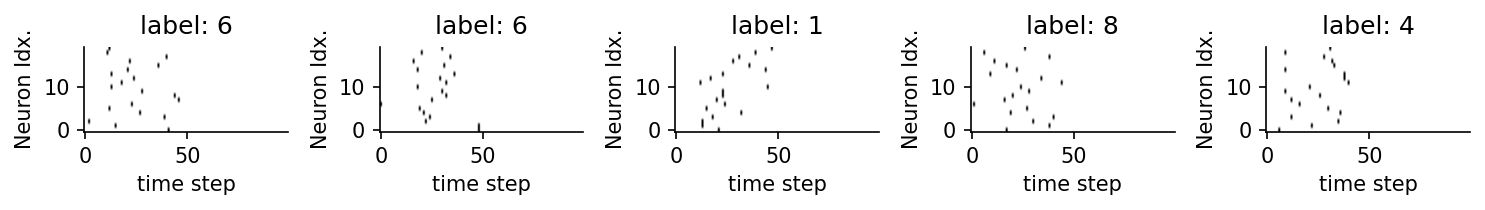

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [7]:
# Model Parameters
batch_size = 250
beta = 20
device = torch.device("cpu")
dtype = torch.float


nb_hidden_units = 128
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

lr = 5e-3
nb_epochs = 50

In [8]:
act_fn = CustomSpike
act_fn.escape_noise_type = "sigmoid"
act_fn.escape_noise_params = {"beta": beta}

act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [9]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    LIFGroup(
        nb_hidden_units,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        activation=act_fn,
    )
)
readout_group = model.add_group(
    ReadoutGroup(
        nb_classes,
        tau_mem=tau_readout,
         tau_syn=tau_syn,
        initial_state=-1e-2,
    )
)

Add synapses between the neuron groups

In [10]:
con = model.add_connection(Connection(input_group, hidden_neurons))
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [11]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    10  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Define regularizer list
regs = []

regLB = LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
regs.append(regLB)
regUB = UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [12]:
sigma_u = 1
nu = nb_spikes / duration

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt, sparseness=0.1
)

ro_initializer = DistInitializer(
    dist=torch.distributions.Normal(0, 1),
    scaling="1/sqrt(k)",
    dtype=dtype,
    sparseness=0.1,
)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=ro_initializer)

Add monitors for spikes and membrane potential

In [13]:
model.add_monitor(SpikeCountMonitor(model.groups[1]))
model.add_monitor(StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [14]:
loss_stack = SumOfSoftmaxCrossEntropy()

We select the SMORMS3 optimizer

In [15]:
opt = SMORMS3
generator = StandardGenerator(nb_workers=2)

In [16]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

plotting


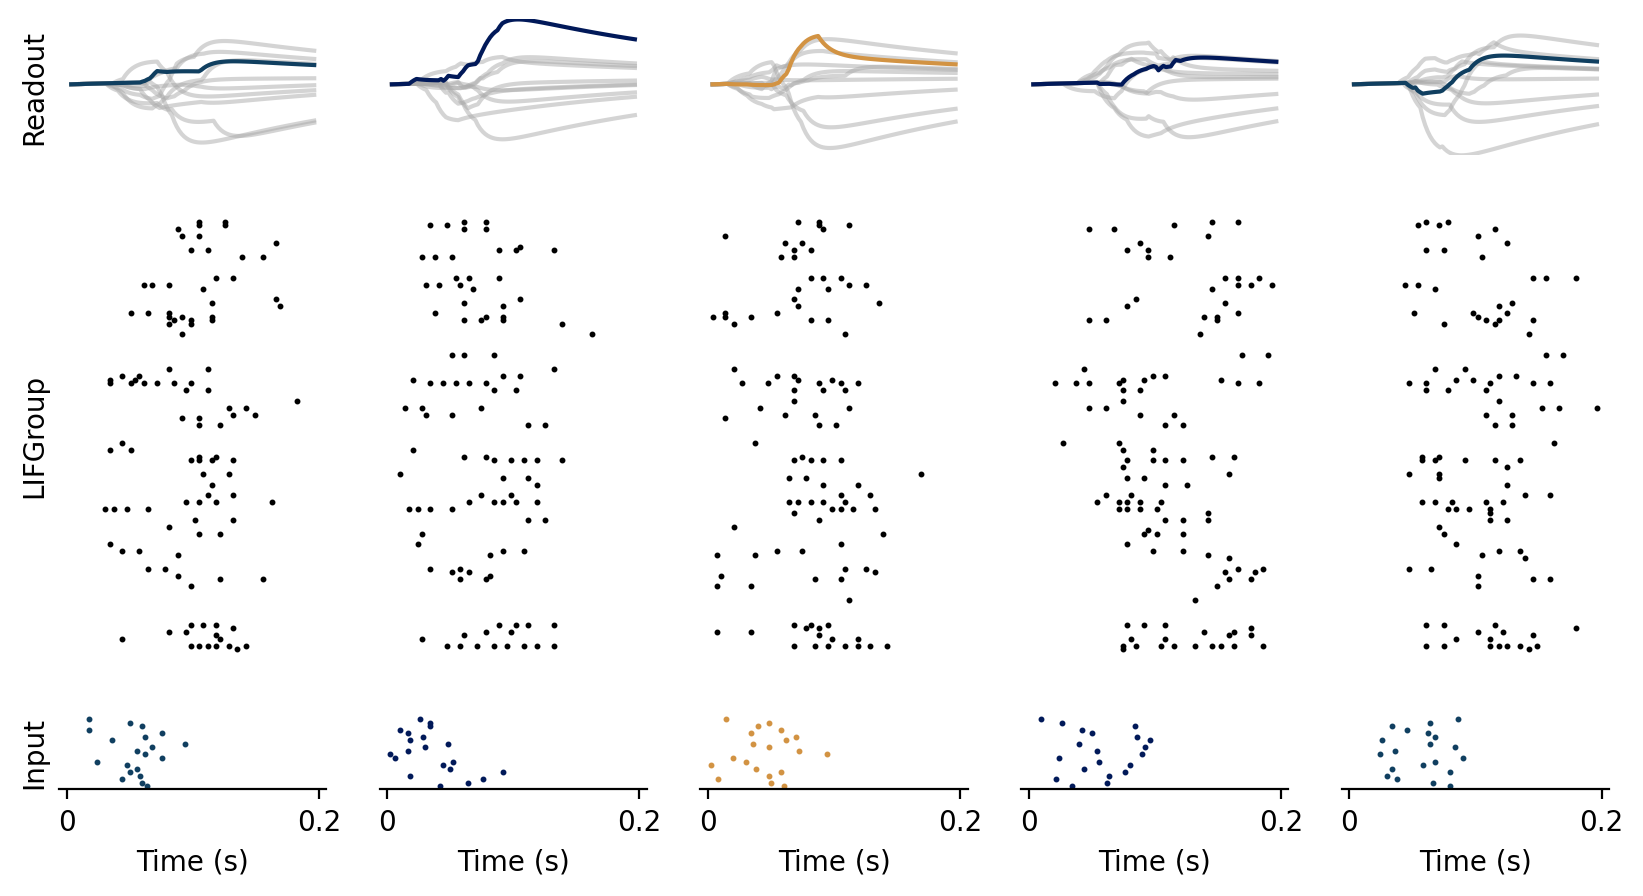

In [17]:
# create nice classification color palette for plotting
colors = cm.batlow(np.linspace(0, 1, nb_classes))

pl = ActivityPlotter(
    model=model,
    data=ds_test,
    nb_samples=5,
    figsize=(10, 5),
    dpi=200,
    plot_label=True,
    label_color="navy",
    batch_size=batch_size,
    pal=colors,
)
fig = pl.plot_activity()

Before we train the model, we monitor the spikes

In [18]:
# Monitors spike counts before training
results = {}

res = model.monitor(ds_test)
for k, v in res.items():
    results["Pre test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(ds_train)
for k, v in res.items():
    results["Pre train " + k] = v.cpu().numpy()
    print(k, v.shape)
# print(results)

SpikeCountMonitor-LIFGroup torch.Size([1000, 128])
StateMonitor-LIFGroup torch.Size([1000, 100, 128])
SpikeCountMonitor-LIFGroup torch.Size([8000, 128])
StateMonitor-LIFGroup torch.Size([8000, 100, 128])


## Training

takes around 13-20 minutes

In [19]:
history = model.fit_validate(ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True)

for k, v in history.items():
    if k in results:
        results[k] = np.concatenate([results[k], v], axis=0)
    else:
        results[k] = np.array(v)

scores = model.evaluate(ds_test).tolist()
print("Scores", scores)
test_dict = model.get_metrics_dict(scores, prefix="test_")

for k, v in test_dict.items():
    if k in results:
        results[k] = np.concatenate([results[k], [v]], axis=0)
    else:
        results[k] = np.array([v])

00  loss = 2.265e+00, reg_loss = 5.748e-05, acc = 17.2% -- val_loss = 2.208e+00, val_reg_loss = 5.599e-05, val_acc = 25.6% t_iter=6.16
01  loss = 2.158e+00, reg_loss = 5.290e-05, acc = 29.3% -- val_loss = 2.061e+00, val_reg_loss = 4.740e-05, val_acc = 39.3% t_iter=5.34
02  loss = 1.984e+00, reg_loss = 4.088e-05, acc = 39.6% -- val_loss = 1.903e+00, val_reg_loss = 3.534e-05, val_acc = 43.3% t_iter=5.35
03  loss = 1.815e+00, reg_loss = 3.166e-05, acc = 46.0% -- val_loss = 1.737e+00, val_reg_loss = 2.846e-05, val_acc = 47.7% t_iter=6.57
04  loss = 1.669e+00, reg_loss = 2.658e-05, acc = 50.5% -- val_loss = 1.586e+00, val_reg_loss = 2.470e-05, val_acc = 52.2% t_iter=6.23
05  loss = 1.533e+00, reg_loss = 2.371e-05, acc = 55.1% -- val_loss = 1.470e+00, val_reg_loss = 2.237e-05, val_acc = 58.7% t_iter=6.31
06  loss = 1.409e+00, reg_loss = 2.211e-05, acc = 58.3% -- val_loss = 1.338e+00, val_reg_loss = 2.145e-05, val_acc = 60.6% t_iter=6.56
07  loss = 1.296e+00, reg_loss = 2.103e-05, acc = 61.4%

plotting


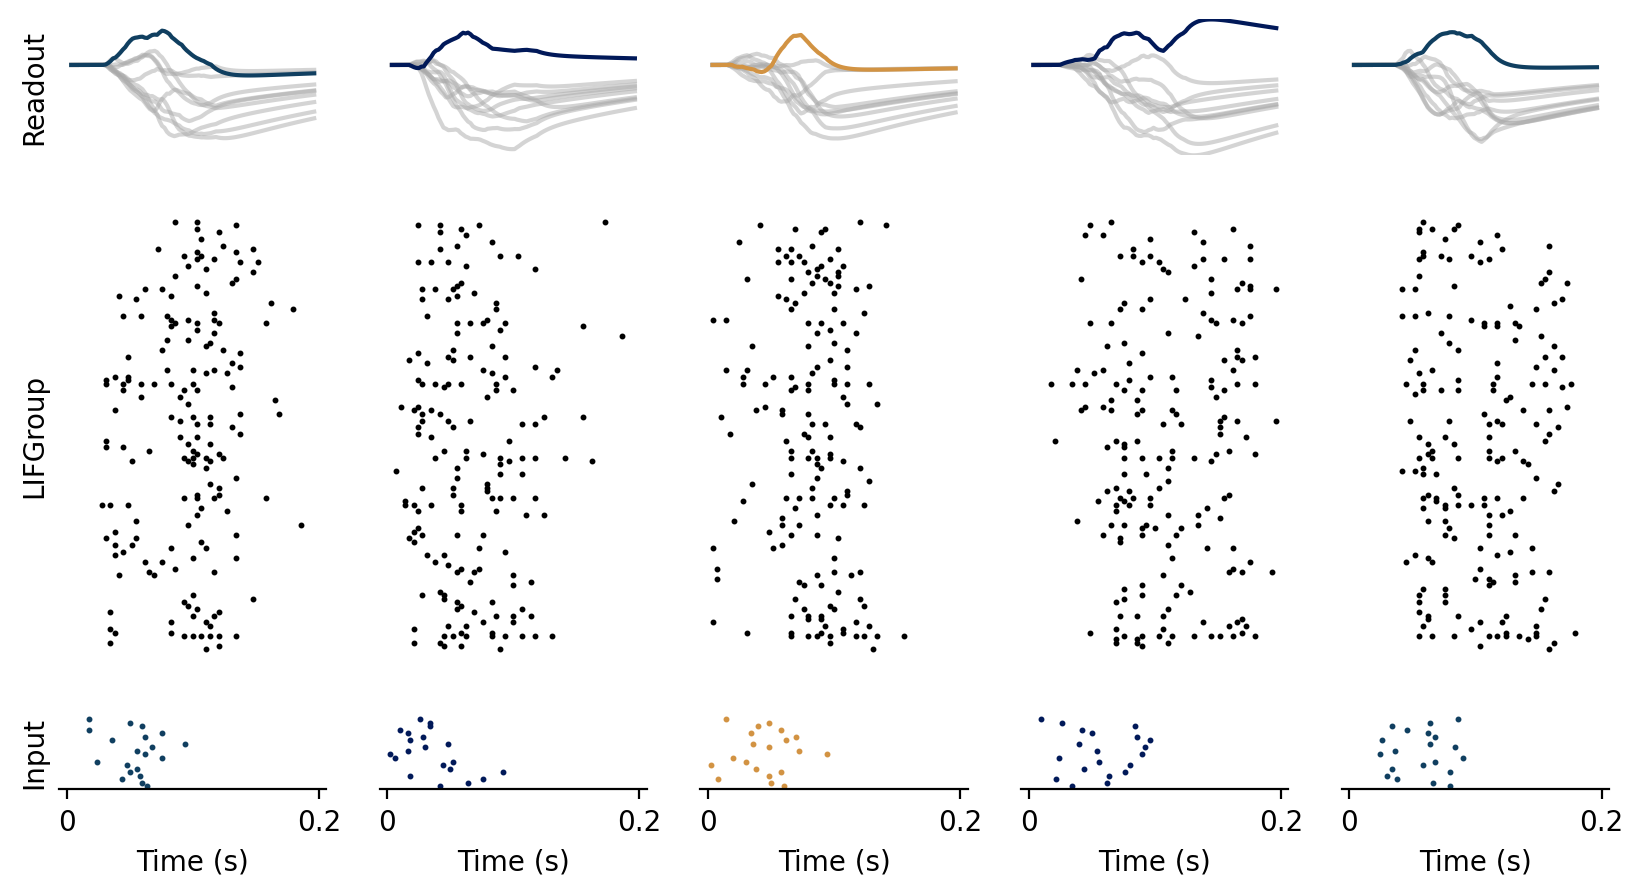

In [20]:
fig = pl.plot_activity()

#### Monitor the model again after training

In [21]:
res = model.monitor(ds_test)
for k, v in res.items():
    results["Post test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(ds_train)
for k, v in res.items():
    results["Post train " + k] = v.cpu().numpy()
    print(k, v.shape)
# print(results)

SpikeCountMonitor-LIFGroup torch.Size([1000, 128])
StateMonitor-LIFGroup torch.Size([1000, 100, 128])
SpikeCountMonitor-LIFGroup torch.Size([8000, 128])
StateMonitor-LIFGroup torch.Size([8000, 100, 128])


## Test

In [22]:
scores = model.evaluate(ds_test).tolist()

Test acc: 0.915


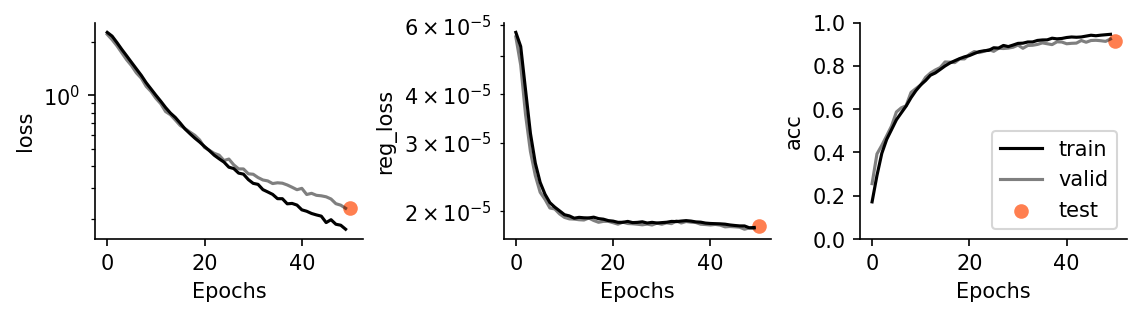

: 

In [ ]:
names = [k for k in results.keys() if not ("val" in k or "test" in k or "Monitor" in k)]

fig = plot_training(
    results,
    nb_epochs=nb_epochs,
    epoch_chunks=1,  # cfg.training.epoch_chunks,
    names=names,
)

print("Test acc:", results["test_acc"][-1])